# LSTM Autoencoder - Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import sys
sys.path.append('../../')
from utils.metrics import calculate_anomaly_metrics, format_results

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

2025-11-21 10:23:54.870773: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 10:23:54.912198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 10:23:56.365200: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# 1. CARGAR DATOS
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 2. FEATURES
feature_cols = [
    'setting_1', 'setting_2', 'setting_3',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
    'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 
    'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21'
]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Features: {len(feature_cols)}")

Train shape: (20631, 18)
Test shape: (13096, 17)
Features: 15


In [3]:
# 3. CREAR BASELINE (30% primeros ciclos)
def get_baseline(df, pct=0.3):
    baseline_list = []
    for unit in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit]
        cutoff = unit_data['time_cycles'].max() * pct
        baseline_list.append(unit_data[unit_data['time_cycles'] <= cutoff])
    return pd.concat(baseline_list)

baseline = get_baseline(train)

# 4. NORMALIZACIÓN
scaler = StandardScaler()
scaler.fit(baseline[feature_cols].values)

print(f"Baseline samples: {len(baseline)}")
print(f"Features: {len(feature_cols)}")

Baseline samples: 6144
Features: 15


In [4]:
# 5. CREAR SECUENCIAS TEMPORALES
window_size = 30  # Ventana de 30 ciclos

def create_sequences(df, feature_cols, window_size, scaler):
    """
    Crea secuencias temporales para cada unidad.
    Retorna: (sequences, indices) donde indices mapea cada secuencia al índice original
    """
    sequences = []
    indices = []
    
    for unit in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit].sort_values('time_cycles')
        values = scaler.transform(unit_data[feature_cols].values)
        
        # Crear ventanas deslizantes
        for i in range(len(values) - window_size + 1):
            sequences.append(values[i:i+window_size])
            # Guardar índice del último punto de la ventana
            indices.append(unit_data.index[i + window_size - 1])
    
    return np.array(sequences), np.array(indices)

# Crear secuencias para baseline
X_baseline, baseline_indices = create_sequences(baseline, feature_cols, window_size, scaler)

print(f"Baseline sequences: {X_baseline.shape}")
print(f"Sequence shape: (samples={X_baseline.shape[0]}, timesteps={X_baseline.shape[1]}, features={X_baseline.shape[2]})")

Baseline sequences: (3244, 30, 15)
Sequence shape: (samples=3244, timesteps=30, features=15)


In [5]:
# 6. ARQUITECTURA LSTM AUTOENCODER
timesteps = window_size
n_features = len(feature_cols)
latent_dim = 32

# Encoder
encoder_inputs = layers.Input(shape=(timesteps, n_features))
x = layers.LSTM(64, activation='relu', return_sequences=True)(encoder_inputs)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(latent_dim, activation='relu', return_sequences=False)(x)
encoder = keras.Model(encoder_inputs, x, name='encoder')

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.RepeatVector(timesteps)(decoder_inputs)
x = layers.LSTM(latent_dim, activation='relu', return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(64, activation='relu', return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(n_features))(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')

# Autoencoder completo
autoencoder_input = layers.Input(shape=(timesteps, n_features))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
lstm_autoencoder = keras.Model(autoencoder_input, decoded, name='lstm_autoencoder')

lstm_autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

lstm_autoencoder.summary()

2025-11-21 10:23:56.767440: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 30, 15)         │        34,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,023 (261.81 KB)

 Trainable params: 67,023 (261.81 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 7. ENTRENAR EN BASELINE
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = lstm_autoencoder.fit(
    X_baseline, X_baseline,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.9635 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6416 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5873 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5626 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5458 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5351 - val_loss: 0.5076 - learning_rate: 0.0010
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5289 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5253 - val_loss: 0.5040 - learning_rate: 0.0010
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5229 - val_loss: 0.5032 - learning_rate: 0.0010
Epoch 10/1

In [7]:
# 8. CALCULAR ERROR EN BASELINE Y DEFINIR UMBRAL
X_baseline_reconstructed = lstm_autoencoder.predict(X_baseline)
baseline_errors = np.mean(np.mean((X_baseline - X_baseline_reconstructed)**2, axis=2), axis=1)

# Umbral: percentil 99 del baseline
threshold = np.percentile(baseline_errors, 99)
print(f"Umbral (p99): {threshold:.6f}")
print(f"Error medio baseline: {baseline_errors.mean():.6f}")
print(f"Error std baseline: {baseline_errors.std():.6f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Umbral (p99): 0.605279
Error medio baseline: 0.501383
Error std baseline: 0.037567


In [8]:
# 9. DETECTAR ANOMALÍAS EN TRAIN
X_train, train_indices = create_sequences(train, feature_cols, window_size, scaler)
X_train_reconstructed = lstm_autoencoder.predict(X_train)

# Error de reconstrucción para cada secuencia
sequence_errors = np.mean(np.mean((X_train - X_train_reconstructed)**2, axis=2), axis=1)

# Inicializar columnas
train['reconstruction_error'] = 0.0
train['is_anomaly'] = 0

# Asignar errores a los índices correspondientes
for idx, error in zip(train_indices, sequence_errors):
    train.loc[idx, 'reconstruction_error'] = error
    train.loc[idx, 'is_anomaly'] = int(error > threshold)

# Propagar valores para las primeras ventanas (que no tienen secuencia)
for unit in train['unit_id'].unique():
    unit_mask = train['unit_id'] == unit
    unit_data = train[unit_mask].sort_values('time_cycles')
    
    # Encontrar primer valor no-cero
    first_valid_idx = unit_data[unit_data['reconstruction_error'] > 0].index
    if len(first_valid_idx) > 0:
        first_error = train.loc[first_valid_idx[0], 'reconstruction_error']
        # Asignar a las primeras filas
        early_indices = unit_data[unit_data['reconstruction_error'] == 0].index
        train.loc[early_indices, 'reconstruction_error'] = first_error
        train.loc[early_indices, 'is_anomaly'] = int(first_error > threshold)

print(f"Total sequences: {len(sequence_errors)}")
print(f"Anomalous sequences: {(sequence_errors > threshold).sum()}")

555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Total sequences: 17731
Anomalous sequences: 5818


In [9]:
# 10. MÉTRICAS
metrics = calculate_anomaly_metrics(train)
metrics['method'] = 'LSTM_Autoencoder'
metrics['dataset'] = 'FD001'
format_results(metrics)

📊 LSTM_Autoencoder - FD001
Cobertura: 100.0% (100/100 unidades)
RUL promedio 1ª detección: 66.8 ciclos
Detección al 67.8% del ciclo
Detecciones tempranas (RUL>50): 67
Falsos positivos (RUL>150): 3.0%
% anomalías totales: 28.3%


/tmp/ipykernel_54014/201548484.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_rate = train.groupby('rul_bin')['is_anomaly'].mean() * 100


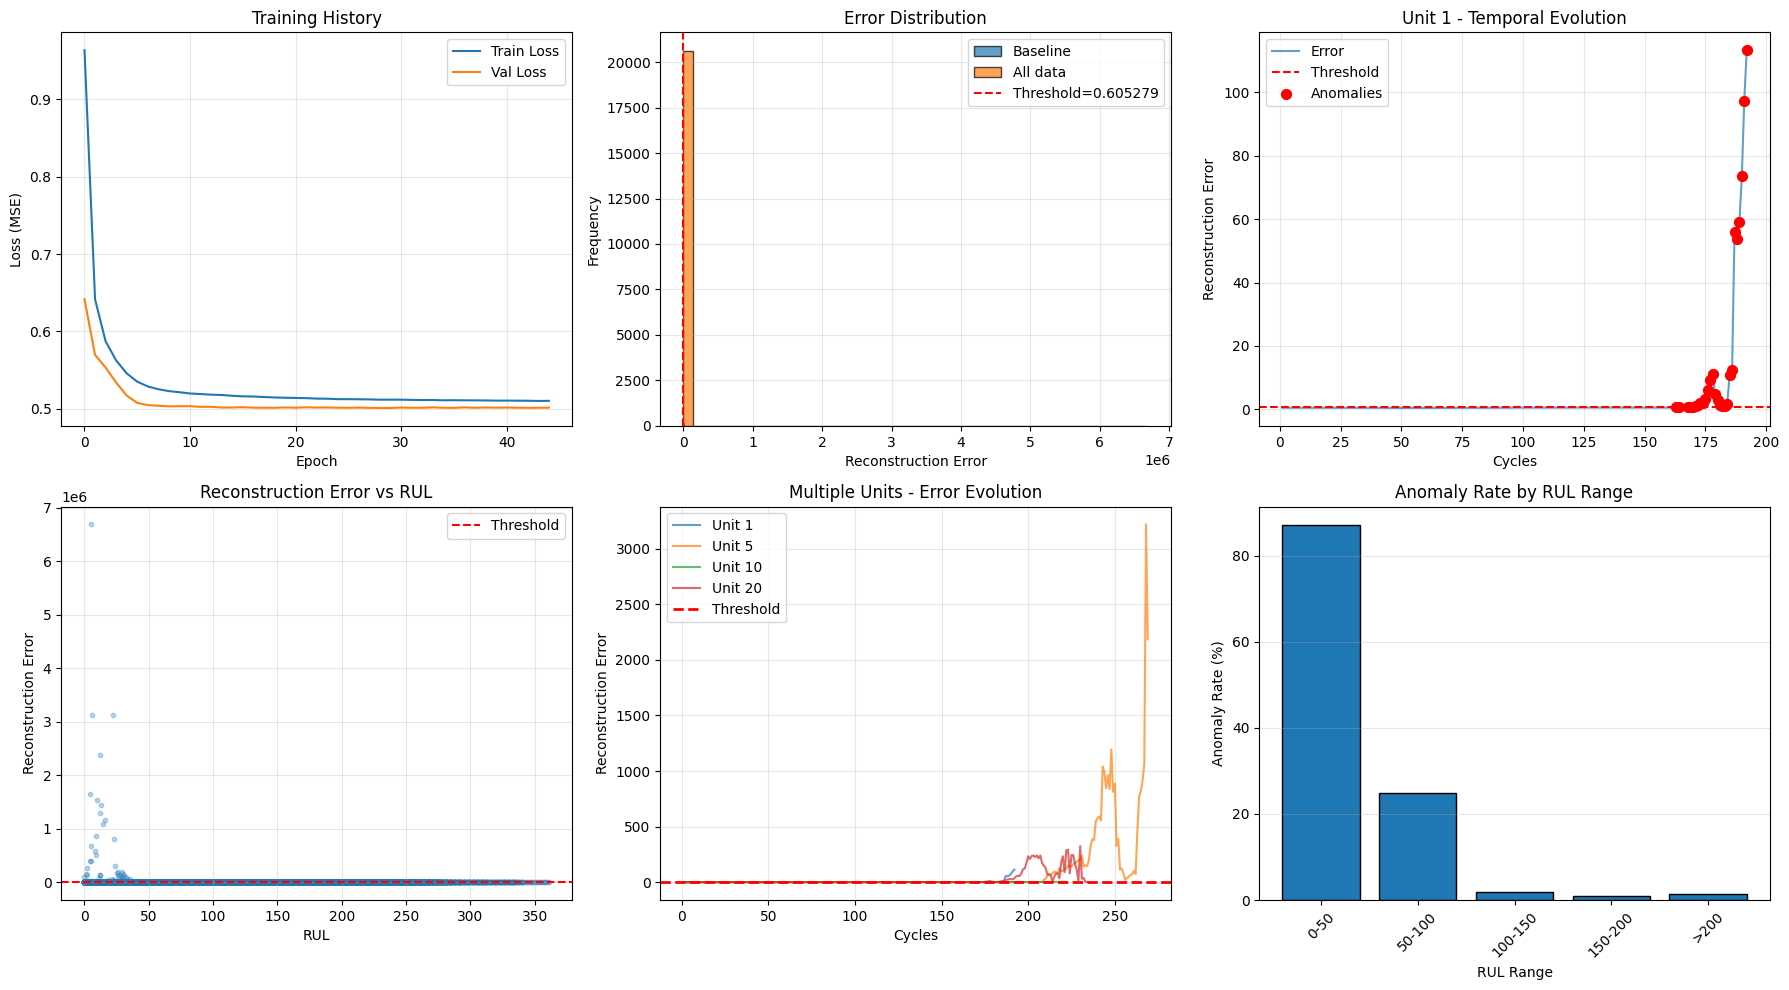

In [10]:
# 11. VISUALIZACIÓN
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# a) Historia del entrenamiento
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training History')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# b) Distribución de errores
axes[0, 1].hist(baseline_errors, bins=50, alpha=0.7, label='Baseline', edgecolor='black')
axes[0, 1].hist(train['reconstruction_error'], bins=50, alpha=0.7, label='All data', edgecolor='black')
axes[0, 1].axvline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.6f}')
axes[0, 1].set_xlabel('Reconstruction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Error Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# c) Evolución temporal ejemplo (unidad 1)
unit_1 = train[train['unit_id'] == 1]
axes[0, 2].plot(unit_1['time_cycles'], unit_1['reconstruction_error'], label='Error', alpha=0.7)
axes[0, 2].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[0, 2].scatter(unit_1[unit_1['is_anomaly']==1]['time_cycles'], 
                   unit_1[unit_1['is_anomaly']==1]['reconstruction_error'], 
                   color='red', s=50, label='Anomalies', zorder=3)
axes[0, 2].set_xlabel('Cycles')
axes[0, 2].set_ylabel('Reconstruction Error')
axes[0, 2].set_title('Unit 1 - Temporal Evolution')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# d) Error vs RUL
axes[1, 0].scatter(train['RUL'], train['reconstruction_error'], alpha=0.3, s=10)
axes[1, 0].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('RUL')
axes[1, 0].set_ylabel('Reconstruction Error')
axes[1, 0].set_title('Reconstruction Error vs RUL')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# e) Evolución temporal para múltiples unidades
for unit_id in [1, 5, 10, 20]:
    unit_data = train[train['unit_id'] == unit_id]
    axes[1, 1].plot(unit_data['time_cycles'], unit_data['reconstruction_error'], 
                    label=f'Unit {unit_id}', alpha=0.7)
axes[1, 1].axhline(threshold, color='r', linestyle='--', label='Threshold', linewidth=2)
axes[1, 1].set_xlabel('Cycles')
axes[1, 1].set_ylabel('Reconstruction Error')
axes[1, 1].set_title('Multiple Units - Error Evolution')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# f) Tasa de anomalías por RUL bin
train['rul_bin'] = pd.cut(train['RUL'], bins=[0, 50, 100, 150, 200, 300], 
                          labels=['0-50', '50-100', '100-150', '150-200', '>200'])
anomaly_rate = train.groupby('rul_bin')['is_anomaly'].mean() * 100
axes[1, 2].bar(range(len(anomaly_rate)), anomaly_rate.values, edgecolor='black')
axes[1, 2].set_xticks(range(len(anomaly_rate)))
axes[1, 2].set_xticklabels(anomaly_rate.index, rotation=45)
axes[1, 2].set_xlabel('RUL Range')
axes[1, 2].set_ylabel('Anomaly Rate (%)')
axes[1, 2].set_title('Anomaly Rate by RUL Range')
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/lstm_autoencoder_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

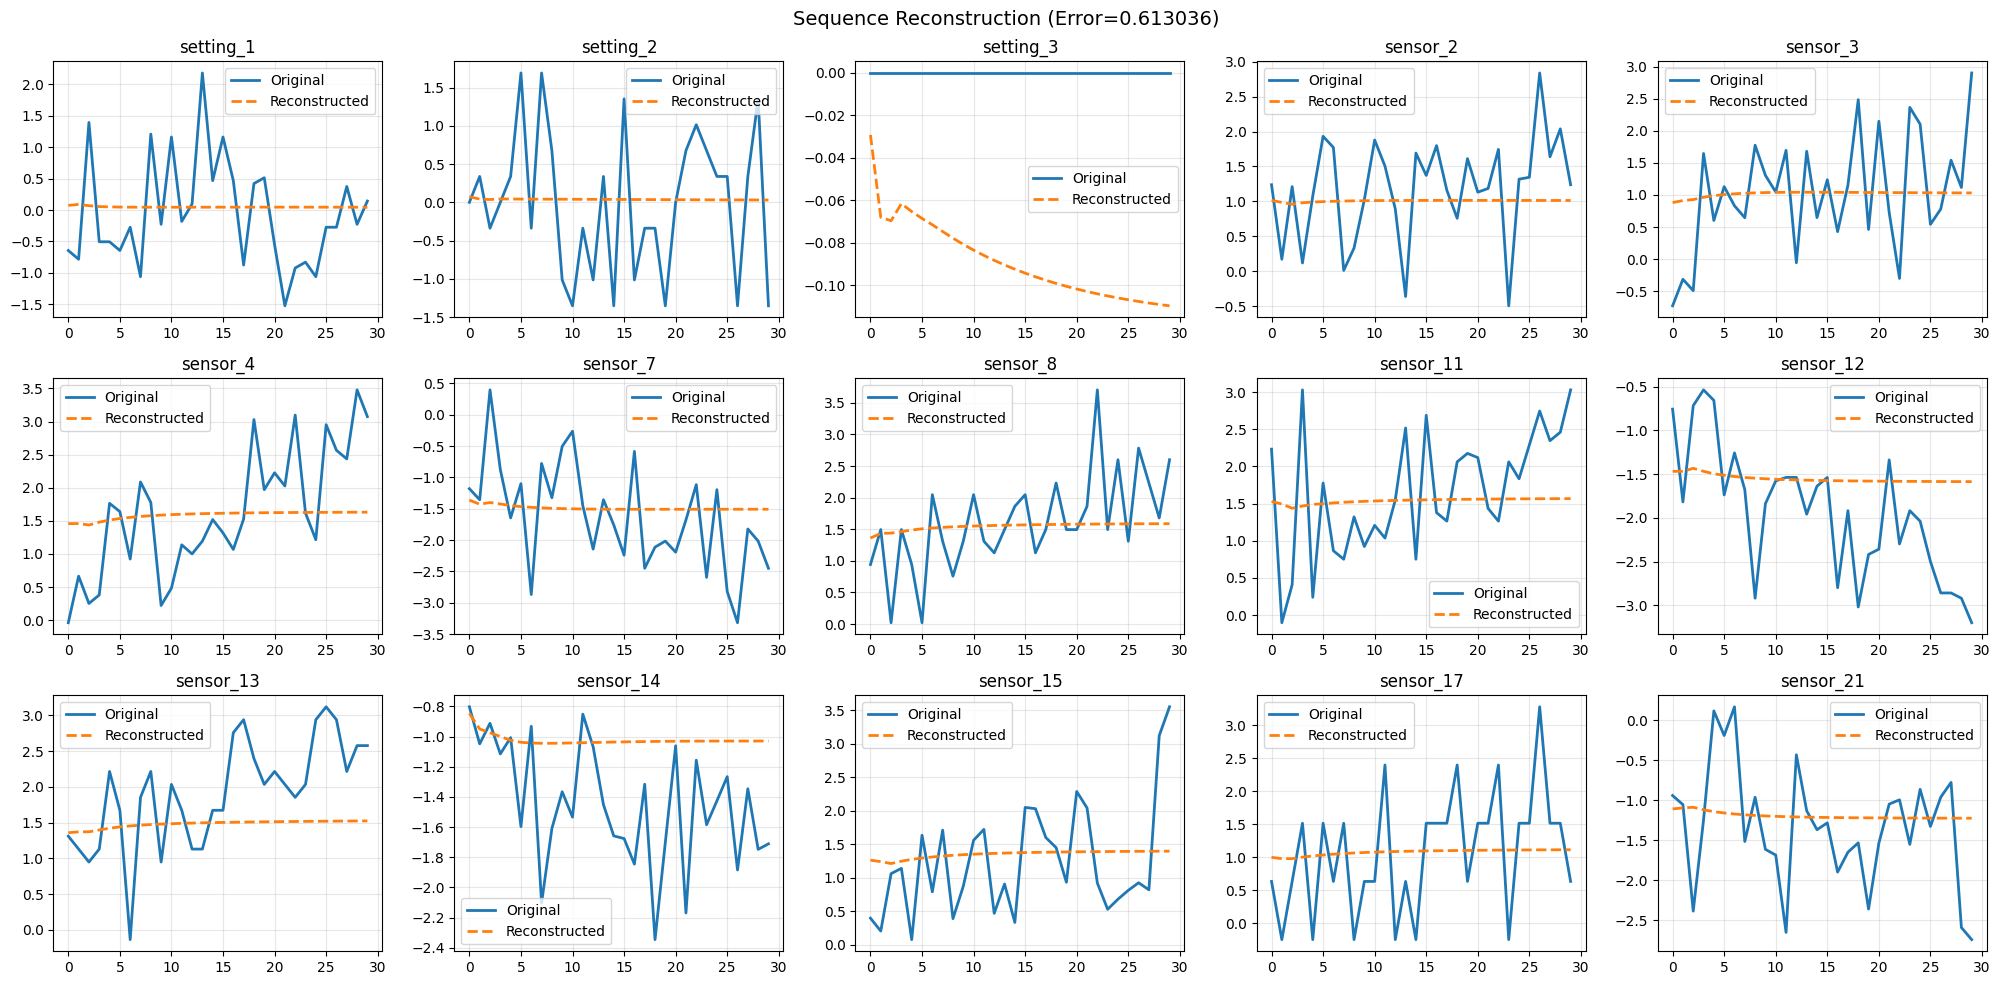

In [11]:
# 12. VISUALIZAR EJEMPLO DE RECONSTRUCCIÓN
# Seleccionar una secuencia anómala
anomalous_idx = np.where(sequence_errors > threshold)[0][0]
original_seq = X_train[anomalous_idx]
reconstructed_seq = X_train_reconstructed[anomalous_idx]

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    axes[i].plot(original_seq[:, i], label='Original', linewidth=2)
    axes[i].plot(reconstructed_seq[:, i], label='Reconstructed', linestyle='--', linewidth=2)
    axes[i].set_title(feature)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle(f'Sequence Reconstruction (Error={sequence_errors[anomalous_idx]:.6f})', fontsize=14)
plt.tight_layout()
plt.savefig('./outputs/lstm_sequence_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# 13. GUARDAR RESULTADOS
output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

# Anomalías detectadas
train[['unit_id', 'time_cycles', 'RUL', 'reconstruction_error', 'is_anomaly']].to_csv(
    output_dir / 'lstm_autoencoder_anomalies.csv', index=False
)

# Métricas
pd.DataFrame([metrics]).to_csv(
    output_dir / 'lstm_autoencoder_metrics.csv', index=False
)

# Guardar modelo
lstm_autoencoder.save(output_dir / 'lstm_autoencoder_model.keras')

print("\n✅ Resultados guardados en ./outputs/")
print(f"   - lstm_autoencoder_anomalies.csv")
print(f"   - lstm_autoencoder_metrics.csv")
print(f"   - lstm_autoencoder_analysis.png")
print(f"   - lstm_sequence_reconstruction.png")
print(f"   - lstm_autoencoder_model.keras")


✅ Resultados guardados en ./outputs/
   - lstm_autoencoder_anomalies.csv
   - lstm_autoencoder_metrics.csv
   - lstm_autoencoder_analysis.png
   - lstm_sequence_reconstruction.png
   - lstm_autoencoder_model.keras
